In [4]:
%env JOBLIB_TEMP_FOLDER=/vol2/tmp

env: JOBLIB_TEMP_FOLDER=/vol2/tmp


In [5]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder

/home/bchnge/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/bchnge/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/bchnge/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
import utils
from importlib import reload
from json import load
import os
import pandas as pd
import numpy as np

In [7]:
kfold = StratifiedKFold(n_splits=5, random_state=123)

In [982]:
reload(utils)

<module 'utils' from '/home/bchnge/projects/kaggle/home-credit-default-risk/utils.py'>

In [8]:
%%time
# Load dataframe
df = utils.load_data(train = True,
                     supp_dict = {'previous_application.csv.zip' : 'max',
                                  'credit_card_balance.csv.zip' : 'mean',
                                  'installments_payments.csv.zip' : 'min',
                                  'POS_CASH_balance.csv.zip' : 'mean',
                                  'bureau.csv.zip' : 'max'
                                 })

Loading training applications
Loading previous_application.csv.zip
Loading credit_card_balance.csv.zip
Loading installments_payments.csv.zip
Loading POS_CASH_balance.csv.zip
Loading bureau.csv.zip
CPU times: user 1min 16s, sys: 19.4 s, total: 1min 36s
Wall time: 1min 36s


In [9]:
%%time
# Create design matrix
features = [x for x in df.columns if x != 'TARGET' and x != 'SK_ID_CURR']
X,y = utils.get_design_matrix_lbl(df, 
                                  features, 
                                  train = True, 
                                  train_test_split = False,
                                  convert_categorical = True)

/home/bchnge/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CPU times: user 3.79 s, sys: 2.45 s, total: 6.24 s
Wall time: 6.25 s


In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet

In [56]:
from sklearn.preprocessing import FunctionTransformer

In [121]:
base_clf = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=5,
 gamma=0.9,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 n_jobs=4,
 scale_pos_weight=1,
 seed=123)


In [126]:
def clean_columns(data):
    return np.apply_along_axis(null_outliers , 0, data)

def null_outliers(x, m = 5):
    z = (x - np.nanmean(x))/np.nanstd(x)
    outliers = abs(z) > m
    x[abs(z) > m] = np.nan
    return x

pipe_clean_columns = FunctionTransformer(func = clean_columns, validate= False)

In [127]:
model = Pipeline([('clean', pipe_clean_columns),          
                  #('impute', Imputer()),
                  #('normalize', RobustScaler()),
                  ('clf', base_clf)
])

In [123]:
model2 = Pipeline([#('clean', pipe_clean_columns),          
                  #('impute', Imputer()),
                  #('normalize', RobustScaler()),
                  ('clf', base_clf)
])

In [ ]:
score = cross_val_score(model, X, y, scoring = 'roc_auc', cv = kfold)

In [203]:
model2.fit(X,y)

KeyboardInterrupt: 

In [129]:
print(score)

[0.78453964 0.78536803 0.78002889 0.78552642 0.78716607]


In [136]:
len(X['CREDIT_TYPE_Credit card'].unique())

3

In [144]:
continuous_vars = [x for x in X.columns if len(X[x].unique()) >= 15]

In [188]:
X_continuous = X.loc[:, continuous_vars]

In [189]:
from xgboost.sklearn import XGBClassifier

In [ ]:
importance = model2.named_steps.clf.feature_importances_

In [196]:
X_continuous_imp = model2.steps

AttributeError: 'list' object has no attribute 'clf'

In [195]:
np.random.seed(123)
score_improvement = {}

for i in range(1000):
    random_vars = list(np.random.choice(X_continuous.columns, size =2, p = replace= False))
    print(random_vars)
    
    X_tmp = X_continuous.loc[:, random_vars ]
    X_tmp['_DIV_'.join(random_vars)] = X_tmp.iloc[:,0] / (X_tmp.iloc[:,1] + 1)

    init_score = cross_val_score(XGBClassifier(n_jobs = 4), X_tmp.loc[:,random_vars], y, scoring = 'roc_auc', cv = 3)
    extended_score = cross_val_score(XGBClassifier(n_jobs = 4), X_tmp, y, scoring = 'roc_auc', cv = 3)

    improvement = extended_score.mean()/init_score.mean()
    
    score_improvement[(random_vars[0], random_vars[1])] = improvement
    print(improvement)


['SK_DPD_DEF_max_4', 'CREDIT_TYPE_Car loan_mean']
0.9998688189484275
['CHANNEL_TYPE_Channel of corporate sales_mean', 'DAYS_TERMINATION_mean']
1.000689993406465
['CHANNEL_TYPE_Contact center_mean', 'AMT_CREDIT_LIMIT_ACTUAL']
0.9981958578952049
['SK_DPD_DEF_mean', 'NAME_GOODS_CATEGORY_Construction Materials_mean']
1.0003331261918658
['LIVINGAREA_MEDI', 'NAME_GOODS_CATEGORY_Furniture_mean']
1.0002699660825707
['AMT_ANNUITY_max', 'AMT_REQ_CREDIT_BUREAU_YEAR']
0.9991149095921736
['AMT_CREDIT_LIMIT_ACTUAL_mean', 'NAME_SELLER_INDUSTRY_MLM partners_mean']
1.0007054370451591
['NAME_PORTFOLIO_Cards_mean', 'NAME_YIELD_GROUP_low_normal_mean']
0.9993374106220483
['NAME_GOODS_CATEGORY_Mobile_mean', 'NAME_GOODS_CATEGORY_Photo / Cinema Equipment_mean']
1.000693391395861
['FLOORSMIN_AVG', 'SELLERPLACE_AREA_mean']
1.0003718040611917
['LANDAREA_MODE', 'DAYS_ENDDATE_FACT']
0.9997154125347315
['CODE_REJECT_REASON_SCOFR_mean', 'AMT_ANNUITY']
0.9986786737186395
['NAME_CASH_LOAN_PURPOSE_Journey_mean', 'NAME_

KeyboardInterrupt: 

In [194]:
score_improvement

{('SK_DPD_DEF_max_4', 'CREDIT_TYPE_Car loan_mean'): 0.9998688189484275,
 ('CHANNEL_TYPE_Channel of corporate sales_mean',
  'DAYS_TERMINATION_mean'): 1.000689993406465,
 ('CHANNEL_TYPE_Contact center_mean',
  'AMT_CREDIT_LIMIT_ACTUAL'): 0.9981958578952049,
 ('SK_DPD_DEF_mean',
  'NAME_GOODS_CATEGORY_Construction Materials_mean'): 1.0003331261918658,
 ('LIVINGAREA_MEDI', 'NAME_GOODS_CATEGORY_Furniture_mean'): 1.0002699660825707,
 ('AMT_ANNUITY_max', 'AMT_REQ_CREDIT_BUREAU_YEAR'): 0.9991149095921736,
 ('AMT_CREDIT_LIMIT_ACTUAL_mean',
  'NAME_SELLER_INDUSTRY_MLM partners_mean'): 1.0007054370451591,
 ('NAME_PORTFOLIO_Cards_mean',
  'NAME_YIELD_GROUP_low_normal_mean'): 0.9993374106220483,
 ('NAME_GOODS_CATEGORY_Mobile_mean',
  'NAME_GOODS_CATEGORY_Photo / Cinema Equipment_mean'): 1.000693391395861,
 ('FLOORSMIN_AVG', 'SELLERPLACE_AREA_mean'): 1.0003718040611917}

In [166]:
from matplotlib import pyplot as plt

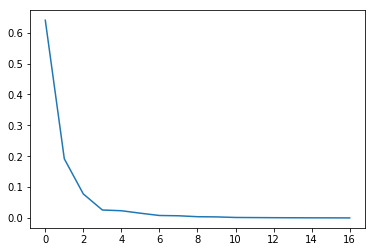

In [168]:
plt.plot(pca.explained_variance_ratio_)

In [147]:
from xgboost.sklearn import XGBClassifier

In [150]:
xgb = XGBClassifier(n_jobs = 4)

In [151]:
score = cross_val_score(Pipeline([('xgb, 
                       X.loc[:, continuous_vars[0:1]], y,
                       scoring = 'roc_auc', cv = 3)


In [152]:
score.mean()

0.5174437304598131

In [ ]:
def add_ratios(X):
    ratios = []
    for i 
    
    X2 = np.hstack((X, ratios))

In [ ]:
FunctionTransformer(lambda X: )

In [146]:
len(continuous_vars)

413

In [143]:
num_values

[{'NAME_CONTRACT_TYPE': 2},
 {'CODE_GENDER': 3},
 {'FLAG_OWN_CAR': 2},
 {'FLAG_OWN_REALTY': 2},
 {'CNT_CHILDREN': 15},
 {'AMT_INCOME_TOTAL': 2548},
 {'AMT_CREDIT': 5603},
 {'AMT_ANNUITY': 13673},
 {'AMT_GOODS_PRICE': 1003},
 {'NAME_TYPE_SUITE': 8},
 {'NAME_INCOME_TYPE': 8},
 {'NAME_EDUCATION_TYPE': 5},
 {'NAME_FAMILY_STATUS': 6},
 {'NAME_HOUSING_TYPE': 6},
 {'REGION_POPULATION_RELATIVE': 81},
 {'DAYS_BIRTH': 17460},
 {'DAYS_EMPLOYED': 12574},
 {'DAYS_REGISTRATION': 15688},
 {'DAYS_ID_PUBLISH': 6168},
 {'OWN_CAR_AGE': 63},
 {'FLAG_MOBIL': 2},
 {'FLAG_EMP_PHONE': 2},
 {'FLAG_WORK_PHONE': 2},
 {'FLAG_CONT_MOBILE': 2},
 {'FLAG_PHONE': 2},
 {'FLAG_EMAIL': 2},
 {'OCCUPATION_TYPE': 19},
 {'CNT_FAM_MEMBERS': 18},
 {'REGION_RATING_CLIENT': 3},
 {'REGION_RATING_CLIENT_W_CITY': 3},
 {'WEEKDAY_APPR_PROCESS_START': 7},
 {'HOUR_APPR_PROCESS_START': 24},
 {'REG_REGION_NOT_LIVE_REGION': 2},
 {'REG_REGION_NOT_WORK_REGION': 2},
 {'LIVE_REGION_NOT_WORK_REGION': 2},
 {'REG_CITY_NOT_LIVE_CITY': 2},
 {'REG_

In [142]:
pd.DataFrame.from_dict(data = num_values)

,AMT_ANNUITY,AMT_ANNUITY_1,AMT_ANNUITY_5,AMT_ANNUITY_max,AMT_ANNUITY_max_5,AMT_ANNUITY_mean,AMT_ANNUITY_mean_5,AMT_APPLICATION,AMT_APPLICATION_max,AMT_APPLICATION_mean,...,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_mean,WEEKDAY_APPR_PROCESS_START_nan,WEEKDAY_APPR_PROCESS_START_nan_max,WEEKDAY_APPR_PROCESS_START_nan_mean,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,13673.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
score = cross_val_score(model, X, y, scoring = 'roc_auc', cv = kfold)
score2 = cross_val_score(model2, X, y, scoring = 'roc_auc', cv = kfold)

/home/bchnge/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/bchnge/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/bchnge/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/bchnge/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/bchnge/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/bchnge/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/bchnge/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/bchnge/anaconda3/lib/python3.6/site-

In [125]:
print(score)
print(score2)

[0.78409319 0.78580252 0.77978392 0.7852083  0.78727098]
[0.78562296 0.78629827 0.7795259  0.78652736 0.78827952]


In [113]:
score_2 = cross_val_score(model2, X, y, scoring = 'roc_auc', cv = kfold, n_jobs= 4)

In [118]:
score_3 = cross_val_score(model2, X, y, scoring = 'roc_auc', cv = kfold, n_jobs= 4)

In [119]:
score_3

array([0.47877825, 0.4775417 , 0.48278194, 0.47738854, 0.48118611])

In [114]:
score_2

array([0.47877825, 0.4775417 , 0.48278194, 0.47738854, 0.48118611])

In [46]:
X.head().T

,0,1,2,3,4
NAME_CONTRACT_TYPE,0.000000,0.000000e+00,1.000000,0.000000,0.000000
CODE_GENDER,1.000000,0.000000e+00,1.000000,0.000000,1.000000
FLAG_OWN_CAR,0.000000,0.000000e+00,1.000000,0.000000,0.000000
FLAG_OWN_REALTY,1.000000,0.000000e+00,1.000000,1.000000,1.000000
CNT_CHILDREN,0.000000,0.000000e+00,0.000000,0.000000,0.000000
AMT_INCOME_TOTAL,202500.000000,2.700000e+05,67500.000000,135000.000000,121500.000000
AMT_CREDIT,406597.500000,1.293502e+06,135000.000000,312682.500000,513000.000000
AMT_ANNUITY,24700.500000,3.569850e+04,6750.000000,29686.500000,21865.500000
AMT_GOODS_PRICE,351000.000000,1.129500e+06,135000.000000,297000.000000,513000.000000
NAME_TYPE_SUITE,6.000000,1.000000e+00,6.000000,6.000000,6.000000


In [43]:
X.shape

(307511, 918)

In [42]:
a.shape

(307511, 59)

In [998]:
%%time
# Initial Model - KNN

base_clf = ElasticNet(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=5,
 gamma=0.9,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 n_jobs=4,
 scale_pos_weight=1,
 seed=123)


#Step 1: Fix learning rate and number of estimators for tuning tree-based parameters
#grid_params = {
# 'max_depth':range(3,10,2), 3
# 'min_child_weight':range(1,6,2) 5
#} 
#Step 2: Tune max_depth and min_child_weight

#Step 3: Tune gamma
#grid_params = {
# 'gamma':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2]
#} 
#Step 4: Tune subsample and colsample_bytree
#grid_params = {
#    'subsample':[0.2, 0.4, 0.6, 0.8, 1],
#    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1]   
#}

# Step 5: Tuning Regularization Parameters
grid_params = {
    'reg_alpha':[0, 0.2, 0.4, 0.6, 0.8, 1],
    'reg_lambda': [0, 0.2, 0.4, 0.6, 0.8, 1]   
}


# Step 6: Reducing Learning Rate

gs = GridSearchCV(estimator = base_clf, param_grid= grid_params, 
                  scoring = 'roc_auc', cv = kfold)

CPU times: user 7.39 ms, sys: 156 ms, total: 164 ms
Wall time: 165 ms


In [998]:
%%time
# Initial Model - determine optimal number of runs (n_estimators) (4:20pm)

base_clf = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=5,
 gamma=0.9,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 n_jobs=4,
 scale_pos_weight=1,
 seed=123)


#Step 1: Fix learning rate and number of estimators for tuning tree-based parameters
#grid_params = {
# 'max_depth':range(3,10,2), 3
# 'min_child_weight':range(1,6,2) 5
#} 
#Step 2: Tune max_depth and min_child_weight

#Step 3: Tune gamma
#grid_params = {
# 'gamma':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2]
#} 
#Step 4: Tune subsample and colsample_bytree
#grid_params = {
#    'subsample':[0.2, 0.4, 0.6, 0.8, 1],
#    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1]   
#}

# Step 5: Tuning Regularization Parameters
grid_params = {
    'reg_alpha':[0, 0.2, 0.4, 0.6, 0.8, 1],
    'reg_lambda': [0, 0.2, 0.4, 0.6, 0.8, 1]   
}


# Step 6: Reducing Learning Rate

gs = GridSearchCV(estimator = base_clf, param_grid= grid_params, 
                  scoring = 'roc_auc', cv = kfold)

CPU times: user 7.39 ms, sys: 156 ms, total: 164 ms
Wall time: 165 ms


In [ ]:
%%time
%%capture 
gs.fit(X,y)
utils.notify_ifttt(pformat(gs.grid_scores_))
utils.notify_ifttt(pformat(gs.best_params_))

In [993]:
gs.best_score_

0.7852508045417719

In [2]:
gs.best_params_

NameError: name 'gs' is not defined

In [1]:
gs.grid_scores_

NameError: name 'gs' is not defined

### It appears that the optimal number of estimators is heavily dependent on the feature space. The more complex, the more trees necessary.

In [975]:
params = {'max_depth': [4],
          'n_estimators': [450, 500, 550, 600, 650, 700],
          'learning_rate': [0.1],
          'colsample_bylevel': [0.4],
          'colsample_bytree': [0.5]}

gs = GridSearchCV(estimator = XGBClassifier(random_state = 123, n_jobs = 4),
                  param_grid = params, scoring = 'roc_auc', cv = kfold, n_jobs = 4)

In [ ]:
%%time
gs.fit(X.loc[:, best_features], y)